## Importing Libraries

In [26]:
import sys, os, random, IPython, warnings, music21
from music21 import *
from IPython.display import Image, Audio
from collections import Counter
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import tensorflow 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
np.random.seed(42)

## Loading Data

To accomplish this project, we are using MIDI files of classical piano music, to be more precise: <ins>**Beethoven's compositions**</ins>.

- Initially, we will generate a list comprising every song in the **Beethoven** folder,parsed as a *music21* stream.

- Later, we will create a function to extract both chords and notes from the data, transforming it into a **corpus**.

### Loading and parsing the midi files as stream

In [8]:
cwd = os.getcwd()
filepath = cwd + "/input/beeth/"

all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

Next, we will extract the elements from these MIDI file streams. The dataset specifies that the MIDI files exclusively contain piano recordings. Hence, the extracted components will consist of either piano chords or individual piano notes.

<ins>Difference between notes and chords:</ins>

- **[NOTE]** The musical notes serve as the building blocks of music, representing pitches associated to distinct audio vibrations. Notably, Western music employs a set of 12 musical notes.

- **[Chord]** A collection of harmonious notes.

The previously created music21 stream in the preceding cell contains a mixture of chords and notes. Our **goal** is to extract them specifically as individual notes, resulting in <ins>a series of notes forming the musical composition</ins>.

### Getting the list of notes as corpus

In [9]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

Corpus= extract_notes(all_midis)
print("Total notes in evey Beethoven midi in the dataset: ", len(Corpus))

Total notes in evey Beethoven midi in the dataset:  81312


## Data Exploration

### Analysing the first 50 values in corpus

All of these values correspond to the notes, as previously mentioned.

In [10]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['C2', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '0.4', '7.0', '2.6', '9.0', '2.6', '9.0', '2.7', '7.11', '7.11', '7.11', 'B3', '7.11', 'A3', 'G3', '7.11', '7.11', '7.11', '7.11', 'C#6', 'D6', '7.11', '7.11', '7.11', 'C6', 'B5']


### Printing the music sheet

In [11]:
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0
    for i in Snippet:
        # in case it is a chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # in case it is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)

        offset += 1

    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
#show(Melody_Snippet)

### Playing the above sheet music

We have generated a ".wav" file with the same content outside of this code. We are using it to establish an audio interface. Now, let's take a moment to listen to the data corpus.

In [28]:
print("Sample Audio From Data")
IPython.display.Audio("../input/music-generated-lstm/Corpus_Snippet.wav", rate=44100) 

Sample Audio From Data


ValueError: could not convert string to float: '../input/music-generated-lstm/Corpus_Snippet.wav'

### Examining every note in the corpus

In [13]:
count_num = Counter(Corpus)
print("Total of unique notes in the corpus: ", len(count_num))

Total of unique notes in the corpus:  349


### Exploring the prev notes dictionary

In [14]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Average recurrency for a note in corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrency for a note in corpus: ", Average(Recurrence))
print("Most frequent note in corpus appeared: ", max(Recurrence), " times")
print("Least frequent note in corpus appeared: ", min(Recurrence), " time")

Average recurrency for a note in corpus:  232.98567335243553
Most frequent note in corpus appeared:  2094  times
Least frequent note in corpus appeared:  1  time


### Plotting the distribution of notes

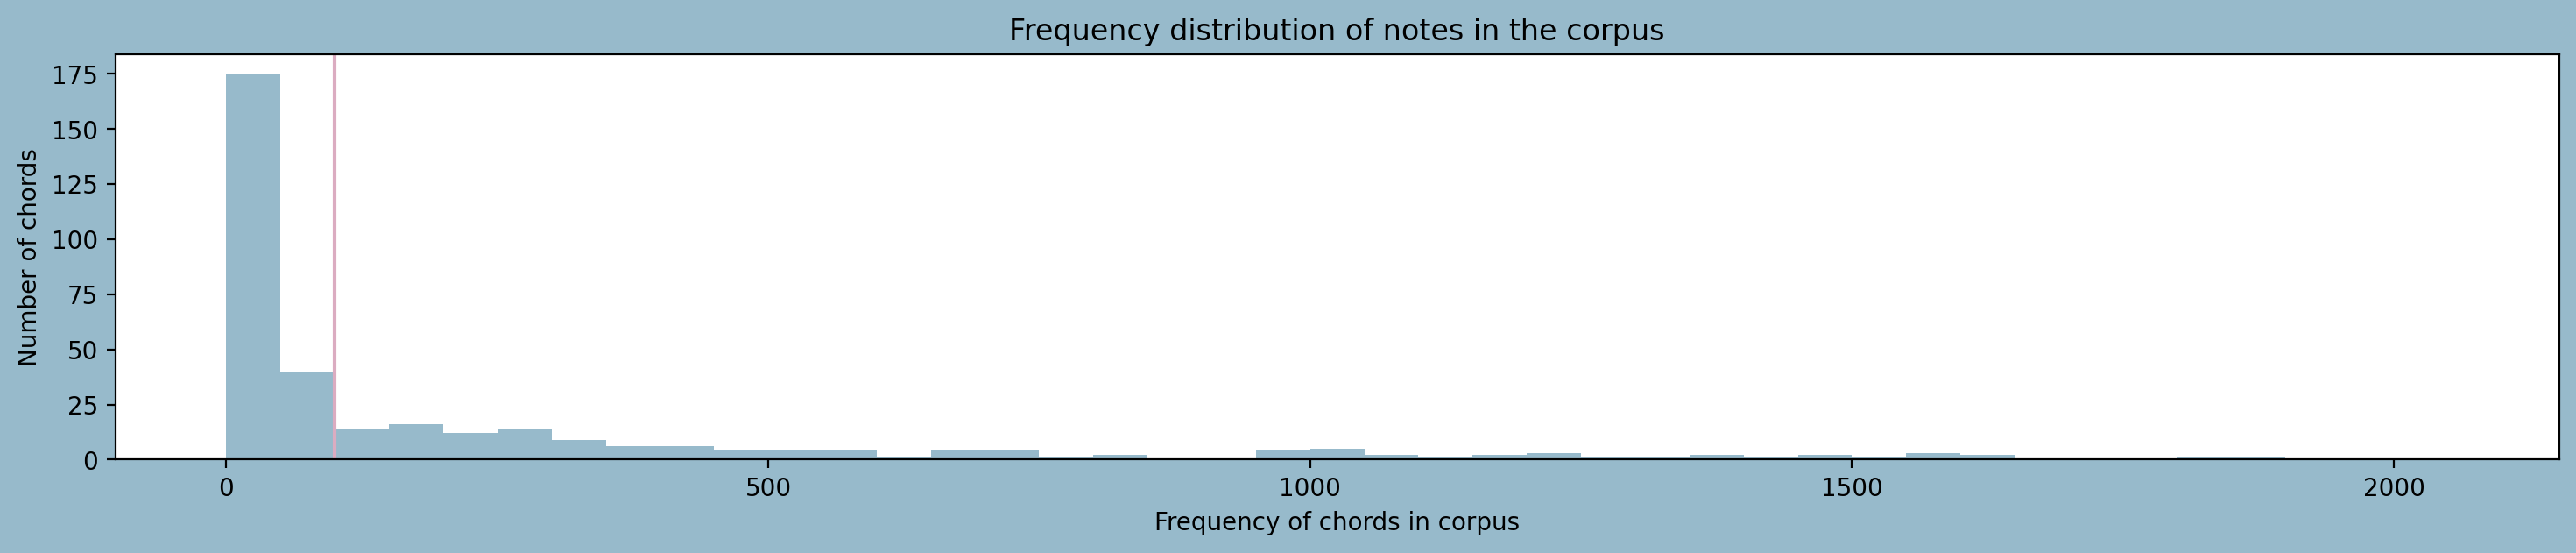

In [15]:
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency distribution of notes in the corpus")
plt.xlabel("Frequency of chords in corpus")
plt.ylabel("Number of chords")
plt.show()

The **existence of rare notes** in the corpus can potentially lead to numerous issues, encountered while composing this piece. To prevent encountering error reports, let's examine the frequency of the notes. For the sake of simplicity, we will exclude some of the least occurring notes.

- **Getting** a list of rare chords

In [16]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times: ", len(rare_note))

Total number of notes that occur less than 100 times:  215


- **Eliminating** the rare notes

In [17]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of corpus after elemination the rare notes: ", len(Corpus))

Length of corpus after elemination the rare notes:  77579


## Data Preprocessing

Notes can be understood as sound waves. In music, we have specific combinations of frequency and wavelength that are standardized as notes. In our corpus, we have the names of these notes. When we loaded the data using the *music21* library, it provided us with the **frequency**, **wavelength**, **duration**, and other information for each note.

### Storing all the unique characters present in my corpus to bult a dictionary

We will create a dictionary to establish a mapping between the notes and their corresponding indices. Since computers perceive these note names as symbols, we need this dictionary to associate each unique note in our corpus with a specific number. This mapping will be used to encode and decode information when interacting with the RNN.

In [18]:
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus)
L_symb = len(symb)

mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters: ", L_corpus)
print("Number of unique characters: ", L_symb)

Total number of characters:  77579
Number of unique characters:  253


### Encoding and splitting the corpus as labels and targets

We will encode the corpus by converting it into smaller sequences of equal length. Each sequence will consist of both the features and the corresponding targets. The features and targets will be represented by the mapped indices from the dictionary, indicating unique characters.

In [19]:
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the corpus: ", L_datapoints)

Total number of sequences in the corpus:  77539


The <ins>labels</ins> will be **reshaped** and **normalized**, while the <ins>targets</ins> themselves will be **one-hot encoded**. These processed inputs will be fed into the RNN for training. However, before that, we need to build the RNN model.

In [20]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

To generate music, we will need to provide some input to the RNN. For this purpose, we will set aside a portion of the data as "seeds." Although we could have trained the model using the entire dataset, as non-musicians, we are not capable of coming up with a suitable input seed value.

In [21]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building

### Initialising and compiling the model for training

In [22]:
model = Sequential()

model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 253)               65021     
                                                                 
Total params: 1970941 (7.52 MB)
Trainable params: 197094

In [24]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200


KeyboardInterrupt: 

## Evaluating models

Having completed the training of our model using the MIDI files of piano music, it's time to evaluate its performance and observe the results.

### Plotting the learning curve for the loss function

In [ ]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning plot of model for loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

### Generating the melody

The idea is to have music in form or a list of chords and notes so that we can convert it into a midi file.

In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi

# notes and melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

This certainly resembles music! However, in order to determine if it truly sounds like music, we need to listen to the MIDI file. Unfortunately, playing MIDI files can be cumbersome. To overcome this limitation, we have saved and converted a few generated melodies to the ".wav" format outside of this notebook. So, let's take a moment to listen and evaluate the melodies.

### Melody generated: Sample 1

In [ ]:
Melody.write('midi','Melody_Generated.mid')
IPython.display.Audio("../input/music-generated-lstm/Melody_Generated 2.wav")

### Melody generated: Sample 2

In [ ]:
IPython.display.Audio("../input/music-generated-lstm/Melody_Generated_1.wav")